# Forest Cover Type Prediction: take 2

In my first exploration / submission to the [Forest Cover Type Prediction Kaggle Competition](https://www.kaggle.com/c/forest-cover-type-prediction), one of the [recommended starter projects](https://www.quora.com/What-Kaggle-competitions-should-a-beginner-start-with-1) I'm working through as part of my [ML Study Curriculum](http://karlrosaen.com/ml), I made some progress:
- developed a preprocessing function to scale each feature
- observed that non-linear models performed significantly better than linear models
- observed that applying tree based methods to scaled data performs the same as on unscaled (so working with the scaled data all the time is fine)
- saw that the first 25 (out of 55) components from PCA are sufficient to preserve 95% of the variance of the data, and it is worth training / predicting based on the reduced dataset with the SVM models, as they are quite slow
- got up to 72% accuracy on submission to kaggle using kernel SVM. A random forest performed almost as well and was *much* faster to train and predict

In this notebook I'm going to see if I can improve performance by tuning the parameters of the two best performing models.

## Loading and preprocessing the data


In [1]:
import pandas as pd

labeled_df = pd.read_csv('train.csv')

labeled_df.head()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### Pipelines FTW

Reading about scikit-learn pipelines in Python Machine Learning and in this [handy post](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html) I got inspired to rework my datamunging function to use pipelines.

It's really nice as once you have it setup, you are in a better position to use many of the libraries for things like kfold cross-validation and hyperparamter tuning with grid search.

Here are some utilities that are handy for preprocessing data. The function `dataframe_wrangler` returns a pipeline that is ready to preprocess a dataframe. You tell it which columns are quantitative and categorical (as well as the range of values for each categorical variable) and it handles scaling them so they will be ready for use with linear classifiers and PCA. Note in the previous notebook we established that, at least for this dataset, working with scaled data does not *hurt* the performance of tree based methods, so we can use the same preprocessing pipeline uniformly for the models we are exploring.

In [2]:
# %load preprocess.py
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler
import functools
import operator
from sklearn.pipeline import Pipeline, FeatureUnion


class BaseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        return self


class ColumnExtractor(BaseTransformer):
    "Helps extract columns from Pandas Dataframe"

    def __init__(self, columns, c_type=None):
        self.columns = columns
        self.c_type = c_type

    def transform(self, X, **transform_params):
        cs = X[self.columns]
        if self.c_type is None:
            return cs
        else:
            return cs.astype(self.c_type)


class CategoricalColumnExtractor(BaseTransformer):

    def __init__(self, cat_vals):
        self.cat_vals = cat_vals

    def all_binary_cs(self):
        binary_cs = [['{}{}'.format(c, v) for v in vs] for c, vs in self.cat_vals.items()]
        return functools.reduce(operator.add, binary_cs)

    def transform(self, X, **transform_params):
        return X[self.all_binary_cs()]


class SpreadBinary(BaseTransformer):

    def transform(self, X, **transform_params):
        return X.applymap(lambda x: 1 if x == 1 else -1)


def dataframe_wrangler(*, quantitative_columns=None, categorical_columns=None):
    """
    Creates a Pipeline that will be ready to preprocess a dataframe.

    :param quantitative_columns: [q_column, ...]
    :param categorical_columns: {'cat_column': ['val1', 'val2', ...]}
    :return: Pipeline
    """
    if quantitative_columns is None:
        quantitative_columns = []
    if categorical_columns is None:
        categorical_columns = {}
    return Pipeline([
        ('features', FeatureUnion([
            ('quantitative', Pipeline([
                ('extract', ColumnExtractor(quantitative_columns, c_type=float)),
                ('scale', StandardScaler())
            ])),
            ('categorical', Pipeline([
                ('extract', CategoricalColumnExtractor(categorical_columns)),
                ('spread_binary', SpreadBinary())
            ])),
        ]))
    ])


### A preproccessing pipeline for our dataset

Let's use this utility to build a pipeline to apply the appropriate scaling to the quantitative and categorical variables in our dataset.

In [3]:
pipe_wrangle = dataframe_wrangler(
    quantitative_columns=['Elevation', 'Aspect', 'Slope', 
          'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
          'Horizontal_Distance_To_Roadways', 
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points'],
    categorical_columns={
        'Wilderness_Area': [1, 2, 3, 4],
        'Soil_Type': list(range(1, 41))
    })

## Tuning 3 models' hyperparameters

Now that we have a pipeline to preprocess the data, we can reuse it with a new pipeline for each model we wish to explore.

Recall that we established the first 24 principal components from PCA retained 95% of the dataset's variance, so we will include that in each pipeline too.

The two models that performed best were kernel SVM and Random Forest. We'll see if we can squeeze a little bit more performance out of each by using grid search to see which models perform best during k-fold validation. We'll throw logistic regression in the mix too since I'm curious how much tuning the regularization parameter will help.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe_lr = Pipeline([
        ('wrangle', pipe_wrangle),
        ('pca', PCA(n_components=24)),
        ('lr', LogisticRegression(C=100.0, random_state=0))
    ])

pipe_rf = Pipeline([
        ('wrangle', pipe_wrangle),
        ('rf', RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1))
    ])

pipe_svm = Pipeline([
        ('wrangle', pipe_wrangle),
        ('pca', PCA(n_components=24)),
        ('svm', SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0))
    ])


### Setting aside a final test set

During parameter tuning, grid search will be using [k-fold cross validation](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold) will be used to see how well the trained model performs on a portion of the data it hasn't seen. But we still want to do a final evaluation step on a portion of the data that was not available during any of the parameter tuning.

In [5]:
from sklearn.cross_validation import train_test_split

labeled_df_train, labeled_df_test = train_test_split(labeled_df, test_size=0.3, random_state=0)
labeled_df_train, labeled_df_test = labeled_df_train.copy(), labeled_df_test.copy()

(labeled_df_train.shape, labeled_df_test.shape)

((10584, 56), (4536, 56))

### X/y extraction

A little helper function to pull out X/y from our dataset

In [6]:
def extract_X_y(df):
    return df.iloc[:, 1:-1], df.iloc[:, -1]

X_train, y_train = extract_X_y(labeled_df_train)

### Tuning Logistic Regression

With our pipeline all setup and our training set ready, we can perform our first grid search with Logistic Regression to see which value for `C`, the regularization parameter that dampens parameter variance, yields the optimal test accuracy.

In [7]:
from sklearn.grid_search import GridSearchCV
import time

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'lr__C': param_range}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=-1)
before_gs = time.time()
gs = gs.fit(X_train, y_train)
after_gs = time.time()

print("grid search across {} parameters took {:.2f} seconds".format(len(param_range), after_gs - before_gs))

grid search across 8 parameters took 12.60 seconds


(0.66128117913832196, {'lr__C': 1000.0})

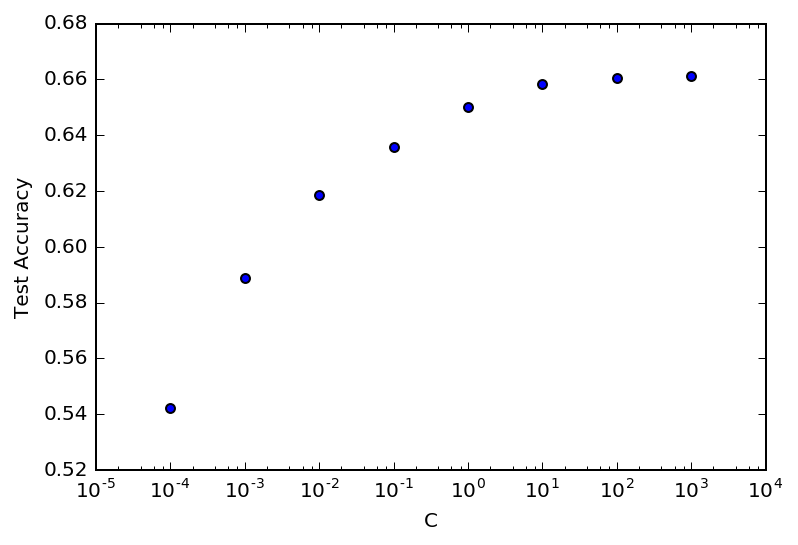

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Test Accuracy')
plt.scatter(
    [score.parameters['lr__C'] for score in gs.grid_scores_],
    [score.mean_validation_score for score in gs.grid_scores_]
)

(gs.best_score_, gs.best_params_)

`C` is the *inverse* regularization parameter so what this is telling us is that LR is performing best when it is free to vary the parameters as much as it likes to fit the data. 

However, our initial stab had `C` set to 100, so we didn't really gain much; by about 10 the performance flattens out

### Tuning Random Forest

Let's see how a random forest classifier performance verifies by the number of estimators, how many estimators make up the ensemble and how many features each classifier gets.

In [9]:
import operator
import functools

def num_params(grid):
    return functools.reduce(
        operator.mul,
        [len(v) for v in grid.values()]
    )

param_grid_rf = { 
    'rf__n_estimators': [10, 50, 100],
    'rf__max_features': ['log2', 'sqrt', 0.8]
}

gs_rf = GridSearchCV(estimator=pipe_rf, 
                     param_grid=param_grid_rf, 
                     scoring='accuracy', 
                     cv=5,
                     n_jobs=-1)
before_gs = time.time()
gs_rf = gs_rf.fit(X_train, y_train)
after_gs = time.time()

print("grid search across {} parameters took {:.2f} seconds".format(num_params(param_grid_rf), after_gs - before_gs))


grid search across 9 parameters took 27.15 seconds


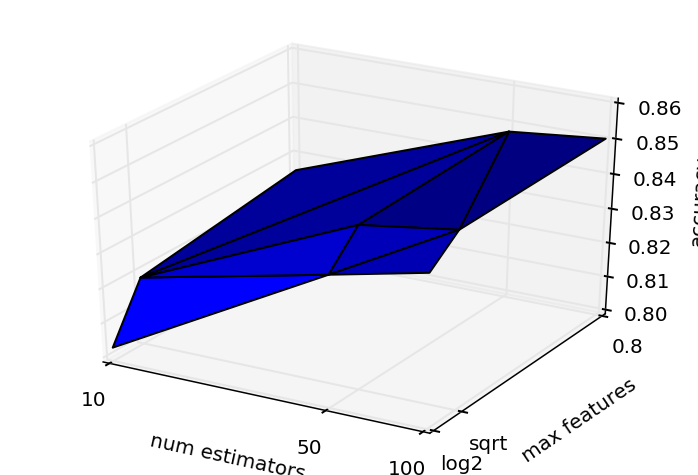

(0.85024565381708239, {'rf__max_features': 0.8, 'rf__n_estimators': 100})

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n_features = X_train.shape[1]
feat_convert = {
    'log2': int(np.log2(n_features)), 
    'sqrt': int(np.sqrt(n_features)),
    0.8: int(0.8 * n_features) 
}

ax.set_xlabel('num estimators')
ax.set_xticks(np.log10([10, 50, 100]))
ax.set_xticklabels([10, 50, 100])
ax.set_ylabel('max features')
ax.set_yticks(np.log10([int(np.log2(n_features)), int(np.sqrt(n_features)), int(0.8 * n_features)]))
ax.set_yticklabels(['log2', 'sqrt', '0.8'])
ax.set_zlabel('accuracy')
ax.plot_trisurf(
    np.log10([score.parameters['rf__n_estimators'] for score in gs_rf.grid_scores_]),
    np.log10([feat_convert.get(score.parameters['rf__max_features']) for score in gs_rf.grid_scores_]),
    [score.mean_validation_score for score in gs_rf.grid_scores_]
)

plt.show()

(gs_rf.best_score_, gs_rf.best_params_)


We were able to get a boost in performance by using more estimators and allowing each one to use more of the variables. If you follow the plan where num_estimators=100 up it's interesting to see that allowing more features still helps.

### Tuning Kernel SVM



In [14]:
param_grid_svm = {
    'svm__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
    'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

gs_svm = GridSearchCV(
    estimator=pipe_svm, 
    param_grid=param_grid_svm,
    scoring='accuracy', 
    cv=3,
    n_jobs=1
)

before_gs = time.time()
gs_svm = gs_svm.fit(X_train, y_train)
after_gs = time.time()

print("grid search across {} parameters took {:.2f} seconds".format(num_params(param_grid_svm), after_gs - before_gs))


grid search across 64 parameters took 836.73 seconds


In [15]:
(gs_svm.best_score_, gs_svm.best_params_)

(0.81122448979591832, {'svm__C': 100.0, 'svm__gamma': 0.1})

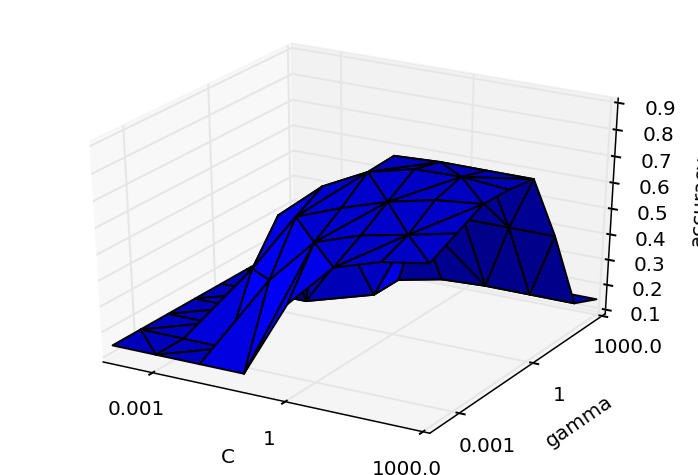

(0.81122448979591832, {'svm__C': 100.0, 'svm__gamma': 0.1})

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('C')
ax.set_xticks(np.log10([0.001, 1, 1000.0]))
ax.set_xticklabels([0.001, 1, 1000.0])
ax.set_ylabel('gamma')
ax.set_yticks(np.log10([0.001, 1, 1000.0]))
ax.set_yticklabels([0.001, 1, 1000.0])
ax.set_zlabel('accuracy')
ax.plot_trisurf(
    np.log10([score.parameters['svm__C'] for score in gs_svm.grid_scores_]),
    np.log10([score.parameters['svm__gamma'] for score in gs_svm.grid_scores_]),
    [score.mean_validation_score for score in gs_svm.grid_scores_]
)

plt.show()

(gs_svm.best_score_, gs_svm.best_params_)

### Learning curves

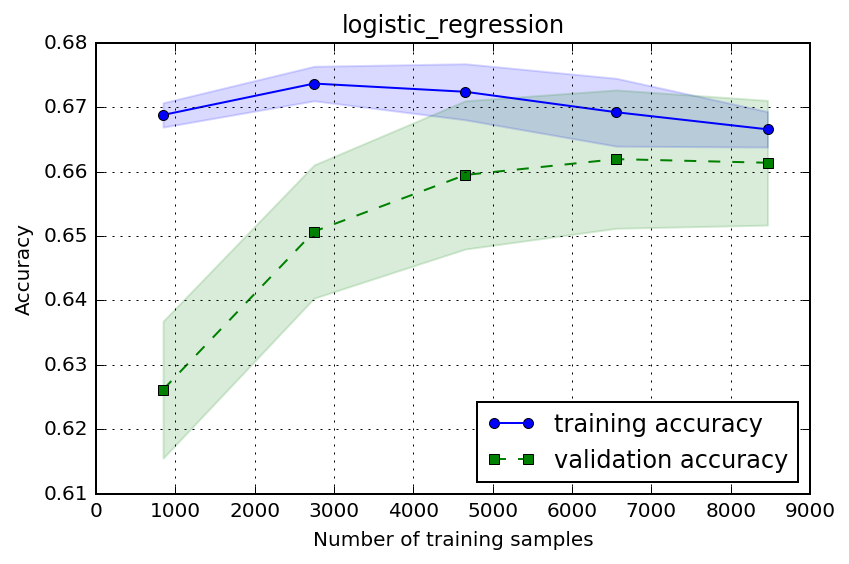

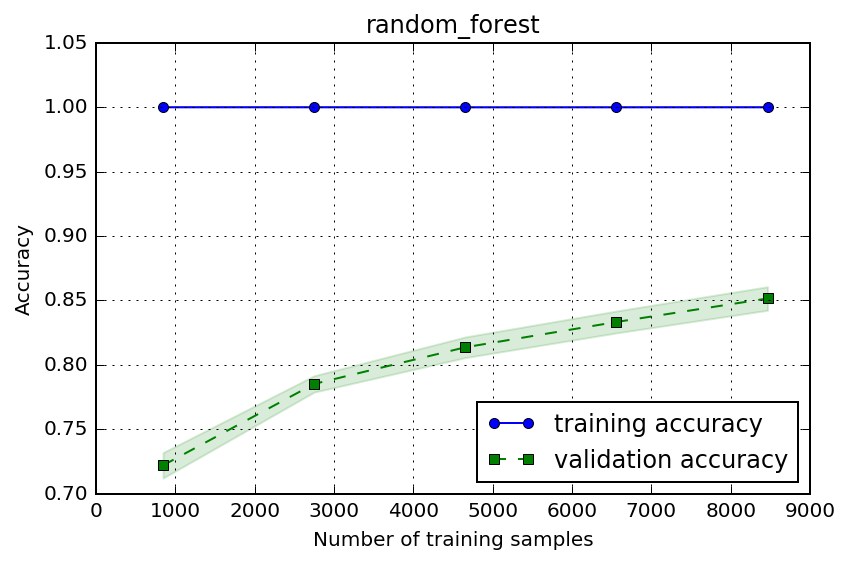

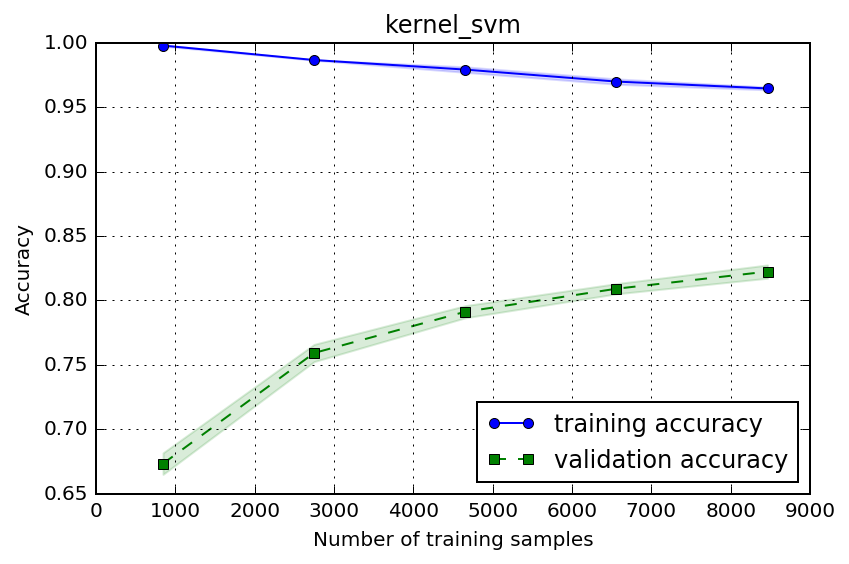

In [74]:
from sklearn.learning_curve import learning_curve

for label, model, orig_params, optimal_params in model_params:
    model.set_params(**optimal_params)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=5,
        n_jobs=1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(label)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    # plt.savefig('./figures/learning_curve.png', dpi=300)
    plt.show()


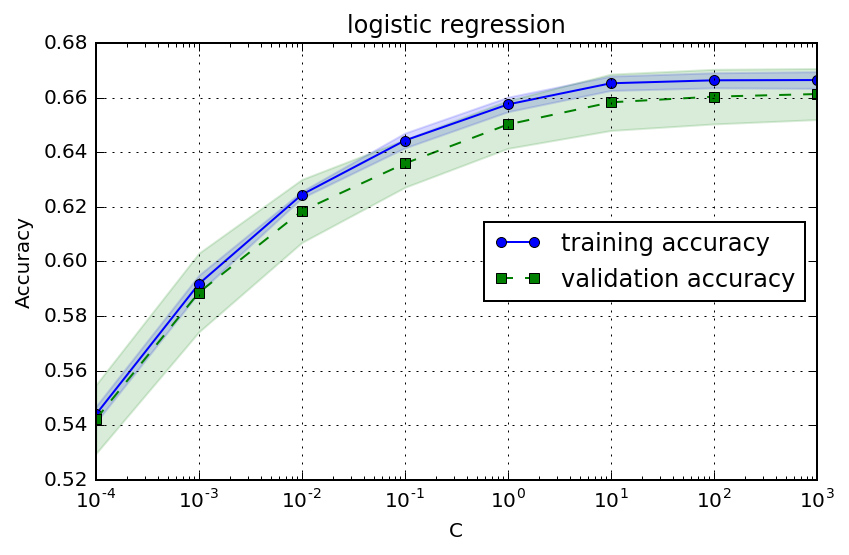

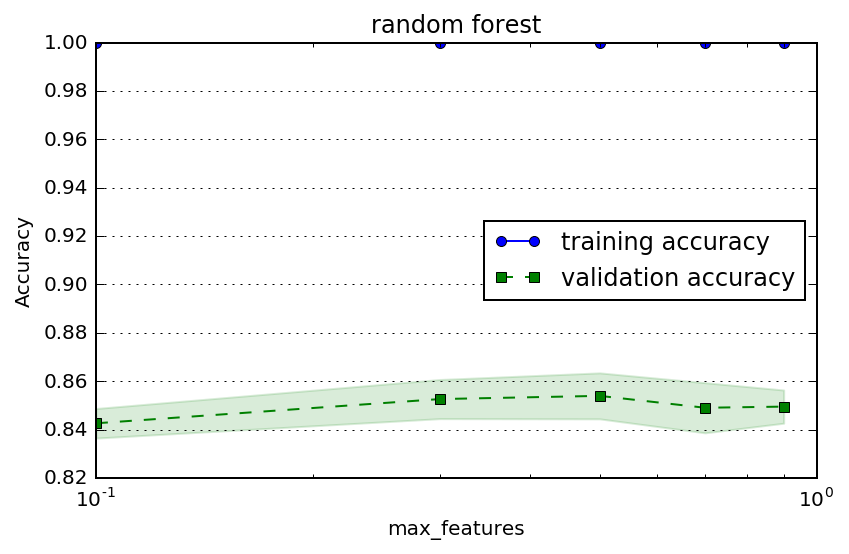

In [79]:
### Validation Curves
from sklearn.learning_curve import validation_curve

pipe_rf.set_params(**{'rf__n_estimators': 100})

model_validations = [
    ('logistic regression', pipe_lr, 'lr__C', [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]),
    ('random forest', pipe_rf, 'rf__max_features', [0.1, 0.3, 0.5, 0.7, 0.9])
]

for label, model, param_name, param_range in model_validations:
    train_scores, test_scores = validation_curve(
                estimator=model, 
                X=X_train, 
                y=y_train, 
                param_name=param_name, 
                param_range=param_range,
                cv=5,
                n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.title(label)
    plt.grid()
    plt.xscale('log')
    plt.legend(loc='center right')
    plt.xlabel(param_name.split('__')[1])
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()


## Final comparison

Let's compare the scores of each model with our original parameters vs optimal for each model.

In [34]:
from sklearn.metrics import accuracy_score

X_test, y_test = extract_X_y(labeled_df_test)

model_params = [
    ('logistic_regression', pipe_lr, 
     {'lr__C': 100}, 
     {'lr__C': 1000}), 
    ('random_forest', pipe_rf, 
     {'rf__n_estimators': 10, 'rf__max_features': 'sqrt'}, 
     {'rf__n_estimators': 100, 'rf__max_features': 0.8}), 
    ('kernel_svm', pipe_svm, 
     {'svm__gamma': 0.10, 'svm__C': 10.0}, 
     {'svm__gamma': 0.10, 'svm__C': 100.0})]

for label, model, orig_params, optimal_params in model_params:
    print("{} performance:".format(label))
    for desc, params in [('orig', orig_params), ('optimal', optimal_params)]:
        model.set_params(**params)
        model.fit(X_train, y_train)
        test_accuracy = accuracy_score(y_test, model.predict(X_test))
        print("\__ with {} params {}: {:.3f}".format(desc, params, test_accuracy))
    
    

logistic_regression performance:
\__ with orig params {'lr__C': 100}: 0.658
\__ with optimal params {'lr__C': 1000}: 0.658
random_forest performance:
\__ with orig params {'rf__max_features': 'sqrt', 'rf__n_estimators': 10}: 0.821
\__ with optimal params {'rf__max_features': 0.8, 'rf__n_estimators': 100}: 0.846
kernel_svm performance:
\__ with orig params {'svm__gamma': 0.1, 'svm__C': 10.0}: 0.815
\__ with optimal params {'svm__gamma': 0.1, 'svm__C': 100.0}: 0.825


## Preparing most promising tuned model for submission

We were able to squeeze a little bit more performance out of our random forest and kernel SVM classifiers, and it was interesting to see how much performance varies by the parameters in the graphs. We happened to pick parameters before tuning that were pretty close to optima but for every model there were some very un-optimal parameters we could have picked too.

Let's train our fine tuned Random Forest model on the entire kaggle training set and prepare another submission.

In [40]:
unlabeled_df = pd.read_csv('test.csv')

X, y = extract_X_y(labeled_df)
X_submit = unlabeled_df.iloc[:, 1:]

pipe_rf.set_params(**{'rf__n_estimators': 1000, 'rf__max_features': 0.8})

pipe_rf.fit(X, y)

submission_df = unlabeled_df[['Id']].copy()
submission_df['Cover_Type'] = pipe_rf.predict(X_submit)
submission_df.to_csv("forest-cover-type-submission-random_forest_estimators_1000_max_features_0.8.csv", index=False)


<table>
<tr>
<th>Model</th>
<th>Untuned Test Accuracy</th>
<th>Tuned Test Accuracy
<th>Untuned Kaggle Score</th>
<th>Kaggle Score</th>
</tr>
<tr>
<td>Logistic Regression</td>
<td>0.658</td>
<td>0.658</td>
<td>0.56</td>
<td></td>
</tr>
<tr>
<td>Kernel SVM</td>
<td>0.815</td>
<td>0.825</td>
<td>0.72143</td>
<td>0.73570</td>
</tr>
<tr>
<td>Random Forest</td>
<td>0.82</td>
<td>0.85</td>
<td>0.71758</td>
<td>0.74463</td>
</tr>
</table>

### Actual best score 0.755 with 1000 tree forest

Note that upon observing that performance continues improves with the number of estimators in the random forest model, I tried one more submission with 1000 estimators. This nearly made my laptop freeze and would have taken forever to run with k-fold cross validation so I just submitted, and got **0.75519**.